In [ ]:
#searching 27 key words and finding maximum of 100 abstract for eacb=h key words

In [4]:
from Bio import Entrez
import os

def fetch_pubmed_articles(keywords, email, output_directory, max_articles=10):
#just to use the pubmed in authentic way I am using the entrez
    Entrez.email = email

    #I will get all the abstract into a dedicated output dir
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for keyword in keywords:
        print(f"Fetching articles for keyword: {keyword}")
        try:
            ##### seearch handdle -searching the keywords to find the articles
            handle = Entrez.esearch(db="pubmed", term=keyword, retmax=max_articles)
            record = Entrez.read(handle)
            handle.close()

            ids = record['IdList']
            articles = []

            for id in ids:
                try:
                    ###fetching (based on ids (pubMed))
                    fetch_handle = Entrez.efetch(db="pubmed", id=id, rettype="abstract", retmode="text")
                    articles.append(fetch_handle.read())
                    fetch_handle.close()
                except Exception as e:
                    print(f"Error fetching article ID {id}: {e}")

            ######eachfiles (the txt files) will be based on the keywords that I use
            sanitized_keyword = "".join(c if c.isalnum() or c in " _-" else "_" for c in keyword)
            output_file = f"{output_directory}/{sanitized_keyword}.txt"

            ###now saving the abstracts
            with open(output_file, 'w') as f:
                f.write("\n\n".join(articles))

            print(f"Fetched {len(articles)} articles for keyword '{keyword}'. Saved to {output_file}.")
        except Exception as e:
            print(f"Error processing keyword '{keyword}': {e}")

if __name__ == "__main__":
    keywords = [
        ##general keywords
        "microbial taxa AND disease",
        "microbiome AND disease",
        "gut microbiota AND health",
        "microbial diversity AND disease",
        "pathogenic microbes AND human health",
        "microbial dysbiosis AND disease",

        #####disease specific (you can add or remove disease)
        "microbiome AND cancer",
        "microbial taxa AND inflammatory bowel disease",
        "oral microbiota AND dental caries",
        "skin microbiome AND eczema",
        "gut microbiota AND diabetes",

        # ## tax focused
        "bacterial taxa AND immunity",
        "fungal microbiota AND infection",
        "viral microbiome AND disease",
        "antimicrobial resistance AND microbial composition",

        #### env types
        "microbiome AND environmental exposure",
        "microbial taxa AND antibiotics",
        "probiotics AND disease prevention",
        "microbiome AND nutrition",

        ##### binf and 16s related 
        "metagenomics AND microbial taxa AND disease",
        "functional profiling AND microbiome AND disease",
        "16S rRNA AND microbial taxa AND disease",
        "biomarker discovery AND microbiota",

        #NLP and such and such
        "microbiome AND text mining",
        "named entity recognition AND microbiome",
        "knowledge graph AND microbial taxa",
        "biomedical NLP AND microbiome research"
    ]

    fetch_pubmed_articles(
        keywords=keywords,
        email="your_email@gmail.com",  ##I removed mine, please place your actual email associated with pubmed
        output_directory="data",  
        max_articles=100  ###here I am allowing a max of 100 abstract per keyword, feel free to start with small numbers
    )


Fetching articles for keyword: microbial taxa AND disease
Fetched 100 articles for keyword 'microbial taxa AND disease'. Saved to data/microbial taxa AND disease.txt.
Fetching articles for keyword: microbiome AND disease
Fetched 100 articles for keyword 'microbiome AND disease'. Saved to data/microbiome AND disease.txt.
Fetching articles for keyword: gut microbiota AND health
Fetched 100 articles for keyword 'gut microbiota AND health'. Saved to data/gut microbiota AND health.txt.
Fetching articles for keyword: microbial diversity AND disease
Fetched 100 articles for keyword 'microbial diversity AND disease'. Saved to data/microbial diversity AND disease.txt.
Fetching articles for keyword: pathogenic microbes AND human health
Fetched 100 articles for keyword 'pathogenic microbes AND human health'. Saved to data/pathogenic microbes AND human health.txt.
Fetching articles for keyword: microbial dysbiosis AND disease
Error fetching article ID 39600870: HTTP Error 400: Bad Request
Fetched 

In [5]:
#in total got about 2400 abstracts from 2400 articles in pub med. 

In [6]:
##Lets combine All Text Files into One

##all .txt files in the data directory into a single file for easier processing.

In [7]:
import os
#i like to write function all the time but free free to use the  for loop without the function
def combine_txt_files(input_directory, output_file):

    combined_text = []
    for filename in os.listdir(input_directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(input_directory, filename)
            with open(file_path, 'r') as f:
                combined_text.append(f.read())

    with open(output_file, 'w') as f:
        f.write("\n\n".join(combined_text))

    print(f"Combined {len(combined_text)} files into {output_file}.")

if __name__ == "__main__":
    combine_txt_files(input_directory="data", output_file="data/combined_abstracts.txt")


Combined 27 files into data/combined_abstracts.txt.


# Now i will just keep the relevant info fromt the txt file
Remove metadata like authors, affiliations, and journal details, retaining only the abstract text.

In [9]:
import re

def extract_abstracts(input_file, output_file):

    with open(input_file, 'r') as f:
        text = f.read()

    ###   #to match sections like BACKGROUND, METHODS, etc., followed by text
    abstracts = re.findall(r"(BACKGROUND|METHODS|RESULTS|CONCLUSIONS):\s(.*?)(?=\n\n|$)", text, re.DOTALL)

    ### actual abstract extracted 
    cleaned_abstracts = [re.sub(r'\s+', ' ', abstract[1].strip()) for abstract in abstracts]

    ####storing the cleaned abs
    with open(output_file, 'w') as f:
        f.write("\n\n".join(cleaned_abstracts))

    print(f"Extracted {len(cleaned_abstracts)} abstracts into {output_file}.")

if __name__ == "__main__":
    extract_abstracts(input_file="data/combined_abstracts.txt", output_file="data/cleaned_abstracts.txt")


Extracted 706 abstracts into data/cleaned_abstracts.txt.


# Perform Named Entity Recognition (NER)

# Identify microbial taxa and disease mentions using a pre-trained SciSpacy biomedical model.

In [8]:
import spacy
import json
import os

def perform_ner(input_file, output_file):

    ### the main guy hahah i mean SciSpacy model
    ## just to confirm the main guy is good to go
    nlp = spacy.load("en_core_sci_sm")
    print("SciSpacy model loaded successfully!")

    ## reading the previously cleaned abs
    with open(input_file, 'r') as f:
        abstracts = f.readlines()

    results = []

    ### lets write a for loop to process each of the abstract using SpaCy model
    for abstract in abstracts:
        doc = nlp(abstract.strip())
        entities = [{"text": ent.text, "label": ent.label_} for ent in doc.ents]
        results.append({"abstract": abstract.strip(), "entities": entities})

    #### output dir confirmation
    output_dir = os.path.dirname(output_file)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    ### JSON saving 
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"Extracted entities from {len(abstracts)} abstracts and saved to {output_file}")

#### file path
input_file = "data/cleaned_abstracts.txt" 
output_file = "output/entities.json"      

#ok now everything ready, lets run the function and pray it works :D 
perform_ner(input_file, output_file)


SciSpacy model loaded successfully!
Extracted entities from 1411 abstracts and saved to output/entities.json


# Inspect the Extracted Entities
After running the NER function, the entities will be saved in output/entities.json. You can load and inspect them to ensure the process worked correctly.

In [9]:
### the extracted entities
with open(output_file, 'r') as f:
    entities = json.load(f)

##.   just the first 3 
for i, result in enumerate(entities[:3]):
    print(f"Abstract {i+1}:")
    print(f"Text: {result['abstract']}")
    print("Entities:")
    for entity in result['entities']:
        print(f"  - {entity['text']} ({entity['label']})")
    print()
 

Abstract 1:
Text: Tongxieyaofang (TXYF) was a traditional Chinese medicine (TCM) formula for the treatment of diarrhea with liver stagnation and spleen deficiency syndrome, but the potential targets and mechanisms have not been fully clarified. This study aims to explore the potential mechanisms of TXYF in alleviating diarrhea using network pharmacology and full-length 16S rRNA gene sequencing. METHODS: Network pharmacology was applied to identify bioactive compounds and potential targets involved in the role of TXYF in alleviating diarrhea. Meanwhile, a model of diarrhea with liver stagnation and spleen deficiency syndrome was constructed by intragastric administration of Folium senna extract combined with restraint and tail pinch stress. The effect of TXYF on intestinal mucosal microbiota of diarrhea mice was analyzed by full-length 16S rRNA gene sequencing. RESULTS: Network pharmacology analysis showed that kaempferol, wogonin, naringenin, and nobiletin were compounds associated wit

# Analyze the Entities
To make the results useful, you can perform basic analysis, as simple as:

Counting the frequency of each entity label.
Listing the most common entities .
or anything (it is jus like EDA)

In [10]:
from collections import Counter

def analyze_entities(entities):

    label_counts = Counter()
    entity_counts = Counter()

    for result in entities:
        for entity in result["entities"]:
            label_counts[entity["label"]] += 1
            entity_counts[entity["text"]] += 1

    print("Entity Label Counts:")
    for label, count in label_counts.most_common():
        print(f"{label}: {count}")

    print("\nMost Common Entities:")
    for entity, count in entity_counts.most_common(10):
        print(f"{entity}: {count}")

###finally looking the labels; anmost commons
analyze_entities(entities)


Entity Label Counts:
ENTITY: 63204

Most Common Entities:
patients: 728
microbial: 584
study: 539
gut microbiota: 417
associated with: 410
abundance: 386
bacterial: 331
diversity: 293
increased: 290
composition: 289


# wRITE the Results to a CSV File
You may want to save the entities into a CSV file for easier sharing or further processing.

In [11]:
import csv

def save_entities_to_csv(entities, output_csv):

    with open(output_csv, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Abstract", "Entity Text", "Entity Label"])

        for result in entities:
            abstract = result["abstract"]
            for entity in result["entities"]:
                writer.writerow([abstract, entity["text"], entity["label"]])

    print(f"Entities saved to {output_csv}")

##@#### csv 
output_csv = "output/entities.csv"
save_entities_to_csv(entities, output_csv)


Entities saved to output/entities.csv


# Filter for Specific Entities
If you're interested in specific entity labels (e.g., "DISEASE", "BACTERIA"), filter the results to focus on those.

# this is just optional and specific to the task or disease you are looking

In [12]:
def filter_entities_by_label(entities, labels):

    filtered = []

    for result in entities:
        filtered_entities = [ent for ent in result["entities"] if ent["label"] in labels]
        if filtered_entities:
            filtered.append({"abstract": result["abstract"], "entities": filtered_entities})

    return filtered

#### filtered levs
desired_labels = ["intestinal", "bacteria"] 
filtered_entities = filter_entities_by_label(entities, desired_labels)

#### new JSON for that
filtered_output_file = "output/filtered_entities.json"
with open(filtered_output_file, 'w') as f:
    json.dump(filtered_entities, f, indent=2)

print(f"Filtered entities saved to {filtered_output_file}")


Filtered entities saved to output/filtered_entities.json


# now moving to the knowledge graph


#



(Extracted from the class note that I provided)
A Knowledge Graph typically consists of:

Nodes: Entities such as diseases, microbial taxa, or other biomedical terms.
Edges: Relationships between nodes, such as "causes," "associated_with," or "treats."
For example:

Entity 1: "Inflammatory Bowel Disease" (Node)
Entity 2: "Bacteroides" (Node)
Relationship: "associated_with" (Edge)

# Entity Data load

In [2]:
import json

#the JSON that we created
with open("output/entities.json", "r") as f:
    data = json.load(f)

####look it done 
print("Sample Abstract and Entities:")
print(data[0])


Sample Abstract and Entities:
{'abstract': 'Tongxieyaofang (TXYF) was a traditional Chinese medicine (TCM) formula for the treatment of diarrhea with liver stagnation and spleen deficiency syndrome, but the potential targets and mechanisms have not been fully clarified. This study aims to explore the potential mechanisms of TXYF in alleviating diarrhea using network pharmacology and full-length 16S rRNA gene sequencing. METHODS: Network pharmacology was applied to identify bioactive compounds and potential targets involved in the role of TXYF in alleviating diarrhea. Meanwhile, a model of diarrhea with liver stagnation and spleen deficiency syndrome was constructed by intragastric administration of Folium senna extract combined with restraint and tail pinch stress. The effect of TXYF on intestinal mucosal microbiota of diarrhea mice was analyzed by full-length 16S rRNA gene sequencing. RESULTS: Network pharmacology analysis showed that kaempferol, wogonin, naringenin, and nobiletin wer

# ### define RelationshiPS

In [2]:
def extract_relationships(data):
    relationships = {
        "Disease": {"Bacteria": "associated_with", "Pathogen": "linked_to"},
        "Pathogen": {"Resistance": "resistant_to", "Antibiotic": "treated_with"},
        "Bacteria": {"Disease": "causes", "Gene": "associated_with"}
    }
    triples = []

    for entry in data:
        entities = entry["entities"]
        for i, entity1 in enumerate(entities):
            for j, entity2 in enumerate(entities):
                if i != j:
                    # Infer relationship based on entity text or label
                    label1 = entity1["label"]
                    label2 = entity2["label"]
                    text1 = entity1["text"].lower()
                    text2 = entity2["text"].lower()

                    # Example: Check if "resistance" or "antibiotic" is mentioned
                    if "resistance" in text2 or "antibiotic" in text2:
                        triples.append((text1, "resistant_to", text2))
                    elif "bacteria" in text1 and "disease" in text2:
                        triples.append((text1, "causes", text2))
                    elif label1 in relationships and label2 in relationships[label1]:
                        relationship = relationships[label1][label2]
                        triples.append((text1, relationship, text2))

    print(f"Extracted {len(triples)} triples.")
    return triples

triples = extract_relationships(data)


Extracted 30691 triples.


In [ ]:
###now the kg

In [5]:
import networkx as nx

def create_knowledge_graph(triples):
    kg = nx.DiGraph()
    for entity1, relationship, entity2 in triples:
        kg.add_edge(entity1, entity2, label=relationship)
    print(f"Graph created with {len(kg.nodes())} nodes and {len(kg.edges())} edges.")
    return kg

kg = create_knowledge_graph(triples)


Graph created with 3923 nodes and 11297 edges.


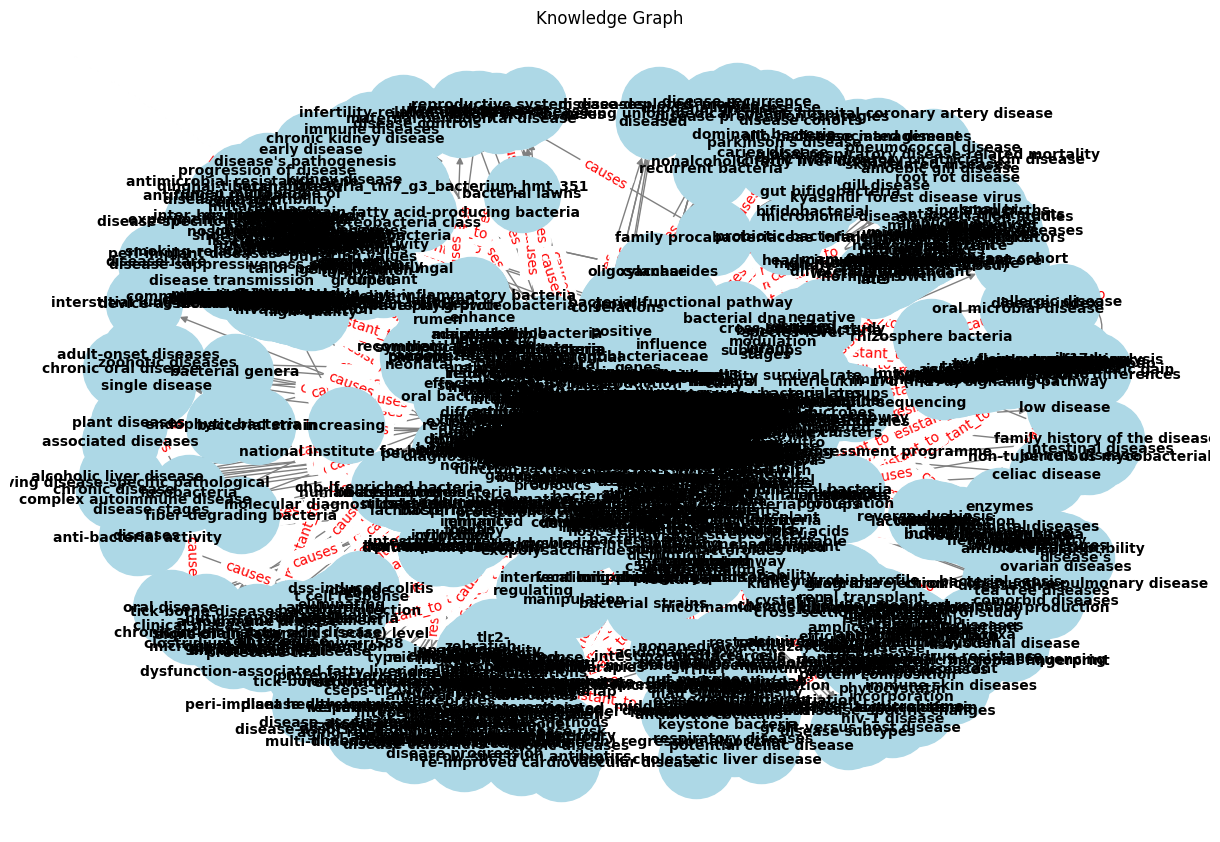

In [8]:
###viz using matplot
## if you encounter the library version descrep at this point.
### just close this notebook in the specefic envelope and open it in base envelope to run the matplot codes

import matplotlib.pyplot as plt

def visualize_knowledge_graph(kg):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(kg, seed=42)
    nx.draw(kg, pos, with_labels=True, node_color="lightblue", node_size=3000, font_size=10, font_weight="bold", edge_color="gray")
    edge_labels = nx.get_edge_attributes(kg, "label")
    nx.draw_networkx_edge_labels(kg, pos, edge_labels=edge_labels, font_color="red")
    plt.title("Knowledge Graph")
    plt.show()

visualize_knowledge_graph(kg)


In [ ]:
# now saving an interavtive knowledge Graph 
# it will be saved as a .html, you can open it with chrome, safari or mfox. 

In [10]:
#pip install pyvis



from pyvis.network import Network

def create_interactive_graph(triples, output_file="knowledge_graph.html"):
    ###init the net 
    net = Network(height="750px", width="100%", notebook=True, directed=True)

    ########nodes ##and edges
    for entity1, relationship, entity2 in triples:
        net.add_node(entity1, label=entity1, title=f"Entity: {entity1}")
        net.add_node(entity2, label=entity2, title=f"Entity: {entity2}")
        net.add_edge(entity1, entity2, title=relationship, label=relationship)

    #### params for the nodes and arrowww
    net.set_options("""
    var options = {
      "nodes": {
        "shape": "dot",
        "size": 25,
        "font": {
          "size": 20,
          "face": "Tahoma"
        }
      },
      "edges": {
        "arrows": {
          "to": { "enabled": true }
        },
        "color": {
          "inherit": true
        },
        "smooth": false
      },
      "physics": {
        "enabled": true,
        "stabilization": {
          "iterations": 1000
        }
      }
    }
    """)

    # Generate and save the graph
    net.show(output_file)
    print(f"Interactive graph saved as {output_file}.")

# Generate the interactive graph
create_interactive_graph(triples)

knowledge_graph.html
Interactive graph saved as knowledge_graph.html.
